In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
context_size = 5
target_size = 50

In [3]:
hidden_size = 128  # Number of neurons in each hidden layer of base model and number of ouput of adaptive network
num_output_adaptive = hidden_size
num_input_setEncoderAr = hidden_size

num_output_setEncoderContext = 128

num_output_setEncoderAr = 128

input_size_adaptation_network = num_output_setEncoderContext + num_output_setEncoderAr

In [4]:
# Define a simple MLP model for regression with 5 hidden layers
num_layers_MLPRegressor = 4         # except the last layer - to be used for number of gamma and beta parameters

class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

In [5]:
# Define a simple MLP model for regression with 5 hidden layers
class adaptiveMLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptiveMLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x_context, y_context, x_target, adaptiveNetwork):
        globalSetEncoderContext = adaptiveNetwork.globalSetEncoderContext
        totalAdaptiveNetworkList = adaptiveNetwork.totalAdaptiveNetworkList

        embeddingContext = globalSetEncoderContext(x_context, y_context)
        embeddingContext = embeddingContext.mean(dim=0).unsqueeze(1)
        embeddingContext = embeddingContext.repeat(1, x_target.shape[0])
        embeddingContext = embeddingContext.T
        gamma_beta_dict0 = totalAdaptiveNetworkList[0](embeddingContext, x_target)

        out = self.fc1(x_target)
        out = self.relu(out)
        out = out * gamma_beta_dict0['gamma'] + gamma_beta_dict0['beta']

        # totalAdaptiveNetworkList[1](embeddingContext, out) -> gamma1, beta1
        gamma_beta_dict1 = totalAdaptiveNetworkList[1](embeddingContext, out)


        out = self.fc2(out)
        out = self.relu(out)
        out = out * gamma_beta_dict1['gamma'] + gamma_beta_dict1['beta']

        # totalAdaptiveNetworkList[2](embeddingContext, out) -> gamma2, beta2
        gamma_beta_dict2 = totalAdaptiveNetworkList[2](embeddingContext, out)

        out = self.fc3(out)
        out = self.relu(out)
        out = out * gamma_beta_dict2['gamma'] + gamma_beta_dict2['beta']

        # totalAdaptiveNetworkList[3](embeddingContext, out) -> gamma3, beta3
        gamma_beta_dict3 = totalAdaptiveNetworkList[3](embeddingContext, out)

        out = self.fc4(out)
        out = self.relu(out)
        out = out * gamma_beta_dict3['gamma'] + gamma_beta_dict3['beta']

        out = self.fc5(out)
        
        return out

In [6]:
class totalAdaptationNetwork(nn.Module):
    def __init__(self, inpute_size_Ar, hidden_size):
        super(totalAdaptationNetwork, self).__init__()
        self.setEncoderArNetwork = setEncoderAr(inpute_size_Ar, hidden_size)
        self.gammaAdaptationNetwork = gammaAdaptationNetwork(input_size_adaptation_network, hidden_size)
        self.betaAdaptationNetwork = betaAdaptationNetwork(input_size_adaptation_network, hidden_size)

    def forward(self, embeddingContext, x_target_activations):
        embeddingAr = self.setEncoderArNetwork(x_target_activations)
        gamma = self.gammaAdaptationNetwork(embeddingContext, embeddingAr)
        beta = self.betaAdaptationNetwork(embeddingContext, embeddingAr)
        return {'gamma': gamma, 'beta': beta}       

In [7]:
class allAdaptationNetworks(nn.Module):
    def __init__(self, hidden_size):
        super(allAdaptationNetworks, self).__init__()
        self.globalSetEncoderContext = setEncoderContext(hidden_size)
        self.encoderArInputSizes = [1, 128, 128, 128]
        self.totalAdaptiveNetworkList = torch.nn.ModuleList()
        for size in self.encoderArInputSizes:
            self.totalAdaptiveNetworkList.append(totalAdaptationNetwork(size, hidden_size))   # List of adaptive networks (which include ArSetEncoder, gammaAdaptaionNetwork, betaAdaptationNetwork for all)

In [8]:
class setEncoderContext(nn.Module):
    def __init__(self, hidden_size):
        super(setEncoderContext, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)            # input_size = 2 (for x and y point)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_setEncoderContext)  # Output layer with one node for regression
        
    def forward(self, x_context, y_context):     # x_y corresponds to a single point
        x_y = torch.cat((x_context, y_context), 1)
        # print(x_y.shape)
        out = self.fc1(x_y)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out    

In [9]:
### change
class setEncoderAr(nn.Module):
    def __init__(self, input_size_Ar, hidden_size):
        super(setEncoderAr, self).__init__()
        ###
        self.fc1 = nn.Linear(input_size_Ar, hidden_size)            # input_size = 2 (for x and y point)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_setEncoderAr)  # Output layer with one node for regression
        
    def forward(self, target_activations):     # x_y corresponds to a single point
        out = self.fc1(target_activations)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out    

In [10]:
class gammaAdaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(gammaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size_adaptation_network, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_adaptive)  # Output layer with one node for regression
        
    def forward(self, embeddingsContext, embeddingsAr):
        # print(embeddingsContext.shape, embeddingsAr.shape)
        embeddings = torch.cat((embeddingsContext, embeddingsAr), dim=1)
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

In [11]:
class betaAdaptationNetwork(nn.Module):
    def __init__(self, input_size_adaptation_network, hidden_size):
        super(betaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size_adaptation_network, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc6 = nn.Linear(hidden_size, num_output_adaptive)  # Output layer with one node for regression
        
    def forward(self, embeddingsContext, embeddingsAr):
        embeddings = torch.cat((embeddingsContext, embeddingsAr), dim=1)
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        return out

In [12]:
def get_sine(sine_params, X, i):
    torch.manual_seed(0)
    return sine_params[i][0] * torch.sin(X + sine_params[i][1]) + torch.randn(X.shape) * 0.1

In [13]:
# Dataset creation

# sine_params = torch.tensor(sine_params)
torch.manual_seed(0)
num_datasets = 10
num_points_per_dataset = 100

A = torch.distributions.Uniform(0.5, 5).sample((num_datasets,))
phi = torch.distributions.Uniform(0, 2 * np.pi).sample((num_datasets,))
sine_params = torch.stack((A, phi), dim=1)

# Generate synthetic data for regression
torch.manual_seed(0)
dataset = [None] * num_datasets  # List of datasets for each function

for i in range(num_datasets):
    # upper_bound = 2 * torch.pi / sine_params[i][1]
    upper_bound = 2 * torch.pi
    X = torch.linspace(0, upper_bound, num_points_per_dataset)
    y = get_sine(sine_params, X, i)  # Sine function with noise
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), 1)
    dataset[i] = X_y

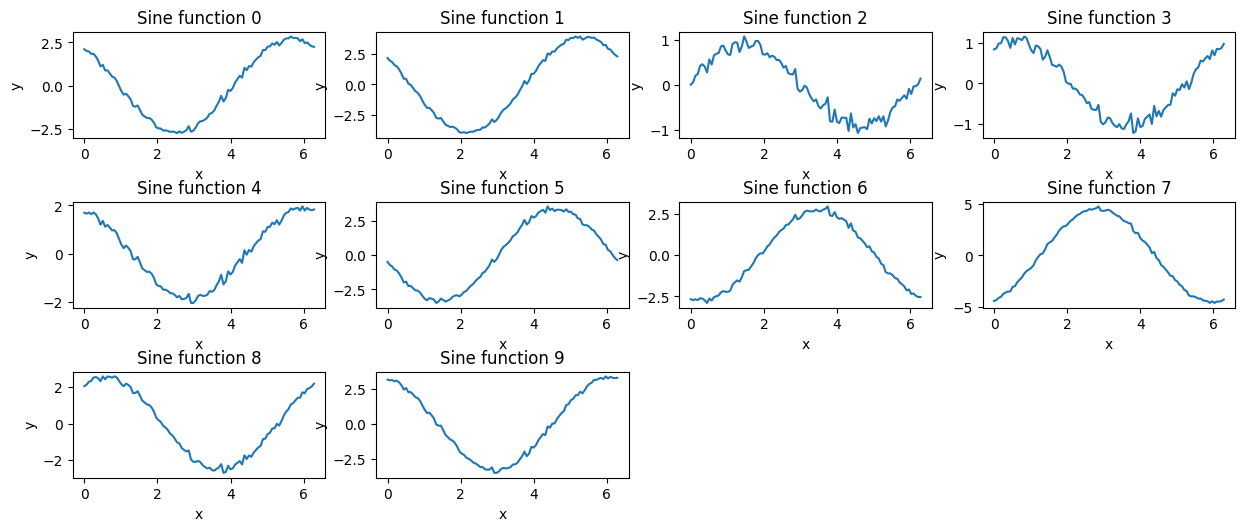

In [14]:
# plot 15 sine functions and adjust margins
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.6)

for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.plot(dataset[i][:, 0].cpu(), dataset[i][:, 1].cpu())
    plt.title('Sine function {}'.format(i))
    plt.xlabel('x')
    plt.ylabel('y')

In [15]:
print('len(dataset): ', len(dataset))
print('len(dataset[0]): ', len(dataset[0]))
print('dataset[0].type(): ', dataset[0].type())

len(dataset):  10
len(dataset[0]):  100
dataset[0].type():  torch.FloatTensor


In [16]:
# Dataset creation for meta learning

newdataset = []
num_datapoints_per_small_task = 50      # this is the number of datapoints we will use for each iteration of meta learning

for i in range(0, len(dataset)):
    torch.manual_seed(i)
    num_elements = dataset[i].shape[0]
    permuted_indices = torch.randperm(num_elements) # Generate a random permutation of indices
    dataset[i] = dataset[i][permuted_indices]
newdataset = dataset
test_dataset = dataset

In [17]:
print('len(newdataset): ', len(newdataset))
print('len(newdataset[0]): ', len(newdataset[0]))

len(newdataset):  10
len(newdataset[0]):  100


In [18]:
input_size = 1



baseModel = MLPRegressor(input_size, hidden_size)


# Initialize the MLP regression baseModel
adaptiveMLPRegModel = adaptiveMLPRegressor(input_size, hidden_size)

# load the trained baseModel
adaptiveMLPRegModel.load_state_dict(torch.load(f'./checkpoints/{context_size}context_200_epochs/adaptiveNetwork_epoch_200.ckpt'))
# adaptiveMLPRegModel = load_base_models_params(adaptiveMLPRegModel)
adaptiveNetwork = allAdaptationNetworks(hidden_size)
adaptiveNetwork.load_state_dict(torch.load(f'./checkpoints/{context_size}context_200_epochs/adaptiveNetwork_actual_epoch_200.ckpt'))


# # freez the weights of the baseModel
# for param in adaptiveMLPRegModel.parameters():
#     param.requires_grad = False


    

# # Initialize the MLP regression baseModel
# adaptiveMLPRegModel = adaptiveMLPRegressor(input_size, hidden_size)
# adaptiveNetwork = allAdaptationNetworks(hidden_size)
# # load the trained baseModel
# adaptiveMLPRegModel.load_state_dict(torch.load('./checkpoints/10context_200_epochs/adaptiveNetwork_epoch_200.ckpt'))


<All keys matched successfully>

In [19]:
adaptiveMLPRegModel

adaptiveMLPRegressor(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)

In [20]:
adaptiveNetwork

allAdaptationNetworks(
  (globalSetEncoderContext): setEncoderContext(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=128, bias=True)
    (fc6): Linear(in_features=128, out_features=128, bias=True)
  )
  (totalAdaptiveNetworkList): ModuleList(
    (0): totalAdaptationNetwork(
      (setEncoderArNetwork): setEncoderAr(
        (fc1): Linear(in_features=1, out_features=128, bias=True)
        (relu): ReLU()
        (fc2): Linear(in_features=128, out_features=128, bias=True)
        (fc3): Linear(in_features=128, out_features=128, bias=True)
        (fc4): Linear(in_features=128, out_features=128, bias=True)
        (fc5): Linear(in_features=128, out_features=128, bias=True)
        (fc6): Linear(in_features=128, out_fe

In [21]:
predictions_y = []
input_x = []
value_y = []
# Make predictions
with torch.no_grad():
    for test_task in test_dataset:
        context_test = test_task[:context_size]
        target_x_test = test_task[context_size:context_size+target_size, 0].unsqueeze(1)
        target_y_test = test_task[context_size:context_size+target_size, 1].unsqueeze(1)
        x_context_test = context_test[:, 0].unsqueeze(1)
        y_context_test = context_test[:, 1].unsqueeze(1)
        predictions = adaptiveMLPRegModel(x_context_test, y_context_test, target_x_test, adaptiveNetwork)
        input_x.append(target_x_test)
        value_y.append(target_y_test)
        predictions_y.append(predictions)

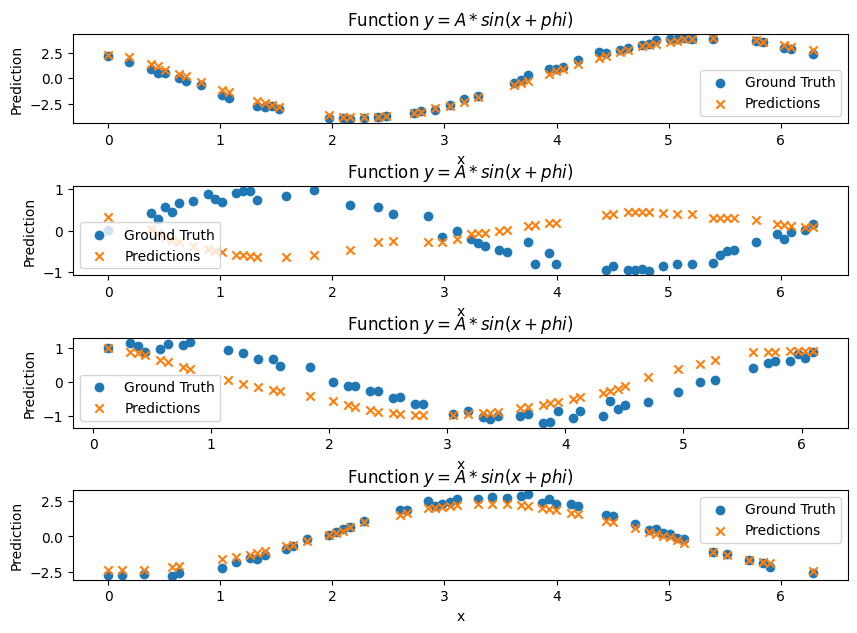

In [22]:
plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.7)

images = [1, 2, 3, 6]

for i in range(len(images)):
    plt.subplot(8,1, i+1)
    plt.scatter(input_x[images[i]].cpu(), value_y[images[i]].cpu(), marker='o', label='Ground Truth')
    plt.scatter(input_x[images[i]].cpu(), predictions_y[images[i]].cpu(), marker='x', label='Predictions')
    plt.xlabel('x')
    plt.ylabel('Prediction')
    plt.title('Function $y = A*sin(x + phi)$'.format(i))
    plt.legend()

# save the plot
plt.savefig(f'./context_comparison_images/{context_size}.png')

# plt.subplot(4,1, 1)
# plt.scatter(input_x[1].cpu(), value_y[1].cpu(), marker='o', label='Ground Truth')
# plt.scatter(input_x[1].cpu(), predictions_y[1].cpu(), marker='x', label='Predictions')

# plt.subplot(4,1, 2)
# plt.scatter(input_x[2].cpu(), value_y[2].cpu(), marker='o', label='Ground Truth')
# plt.scatter(input_x[2].cpu(), predictions_y[2].cpu(), marker='x', label='Predictions')

# plt.subplot(4,1, 3)
# plt.scatter(input_x[3].cpu(), value_y[3].cpu(), marker='o', label='Ground Truth')
# plt.scatter(input_x[3].cpu(), predictions_y[3].cpu(), marker='x', label='Predictions')

# plt.subplot(4,1, 4)
# plt.scatter(input_x[6].cpu(), value_y[6].cpu(), marker='o', label='Ground Truth')
# plt.scatter(input_x[6].cpu(), predictions_y[6].cpu(), marker='x', label='Predictions')
# plt.xlabel('x')
# plt.ylabel('Prediction')
# plt.title('Function $y = A*sin(x + phi)$'.format(i))
# plt.legend()